# Loan Default Prediction


In [1]:
# !pip install tabulate

In [2]:
import os
import pandas as pd
from sklearn import preprocessing,metrics
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tabulate

### Loading Data

In [4]:
dataset = pd.read_csv(r'/content/accepted_2007_to_2018Q4.csv')

In [5]:
dataset['last_pymnt_amnt']

,last_pymnt_amnt
0,122.67
1,926.35
2,15813.30
3,829.90
4,10128.96
...,...
2260696,859.56
2260697,564.56
2260698,329.33
2260699,NaN


## Data Cleaning

- Merged datasets from 2012 to 2014.
- Dropped all empty columns containing borrowers' personal data, as these were not disclosed by the company.
- Encoded target variable (whether the borrower is a loan defaulter) to binary values: 0 or 1.

In [6]:
target_data = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= target_data.replace({"loan_status": di})
dataset['issue_d'] = pd.to_datetime(dataset['issue_d'])
dataset['issue_d'].dtype
dataset = (dataset['issue_d'] >= '2012-01-01') & (dataset['issue_d'] <= '2014-12-31')

In [7]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (1345310, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,...,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,...,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,...,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dataset=Dataset_withBoolTarget.dropna(thresh = 300000,axis=1) #340000 is minimum number of non-NA values
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (1345310, 110)


In [10]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #'sub_grade' #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
# Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (1345310, 18)


In [11]:
Final_data.describe().round(2)

,funded_amnt,annual_inc,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
count,1345310.00,1345310.00,1345310.00,1298029.00,1345310.00,1345310.00,1345310.00,1277783.00,1277782.00,1277782.00,1283398.00,1284167.00,1277761.00,1298029.00,1345310.0
mean,14411.56,76247.64,5423.57,1.67,0.22,13.24,11.59,5.64,13.12,181.48,59.94,10186.23,13488.61,4.69,0.2
std,8713.12,69925.10,7118.00,2.00,0.60,4.77,5.47,3.30,16.34,94.51,28.29,15350.84,16289.70,3.19,0.4
min,500.00,0.00,0.00,0.00,0.00,5.31,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.0
25%,8000.00,45780.00,398.52,0.00,0.00,9.75,8.00,3.00,4.00,117.00,38.30,1464.00,3101.00,2.00,0.0
50%,12000.00,65000.00,2042.05,1.00,0.00,12.74,11.00,5.00,8.00,164.00,63.20,4700.00,7407.00,4.00,0.0
75%,20000.00,90000.00,8250.57,3.00,0.00,15.99,14.00,7.00,16.00,230.00,84.80,12383.00,18717.00,6.00,0.0
max,40000.00,10999200.00,42192.05,51.00,86.00,30.99,90.00,63.00,438.00,852.00,339.60,559912.00,958084.00,64.00,1.0


## Data Transformation


- Grade: Borrower's grade based on past credit history, encoded into numerical values.
- Home Ownership: A feature in the dataset that was encoded into numerical values.
- Employment Length: This feature had inconsistent formatting, with values like "10+ years" or "5 years." These were converted to numerical values in the following cell.

In [12]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].fillna(0).apply(lambda x:int(x))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (1345310, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,3600.0,10,55000.0,6,5,122.67,1.0,0.0,13.99,7.0,4.0,3.0,128.0,37.2,1506.0,20701.0,4.0,0
1,24700.0,10,65000.0,6,5,926.35,4.0,0.0,11.99,22.0,5.0,2.0,192.0,27.1,57830.0,9733.0,4.0,0
2,20000.0,10,63000.0,6,6,15813.30,5.0,0.0,10.78,6.0,3.0,14.0,184.0,55.9,2737.0,31617.0,6.0,0
3,10400.0,3,104433.0,6,2,10128.96,6.0,0.0,22.45,12.0,6.0,4.0,210.0,77.5,4567.0,27644.0,10.0,0
4,11950.0,4,34000.0,5,5,7653.56,0.0,0.0,13.44,5.0,3.0,32.0,54.0,91.0,844.0,2560.0,0.0,0


<Axes: >

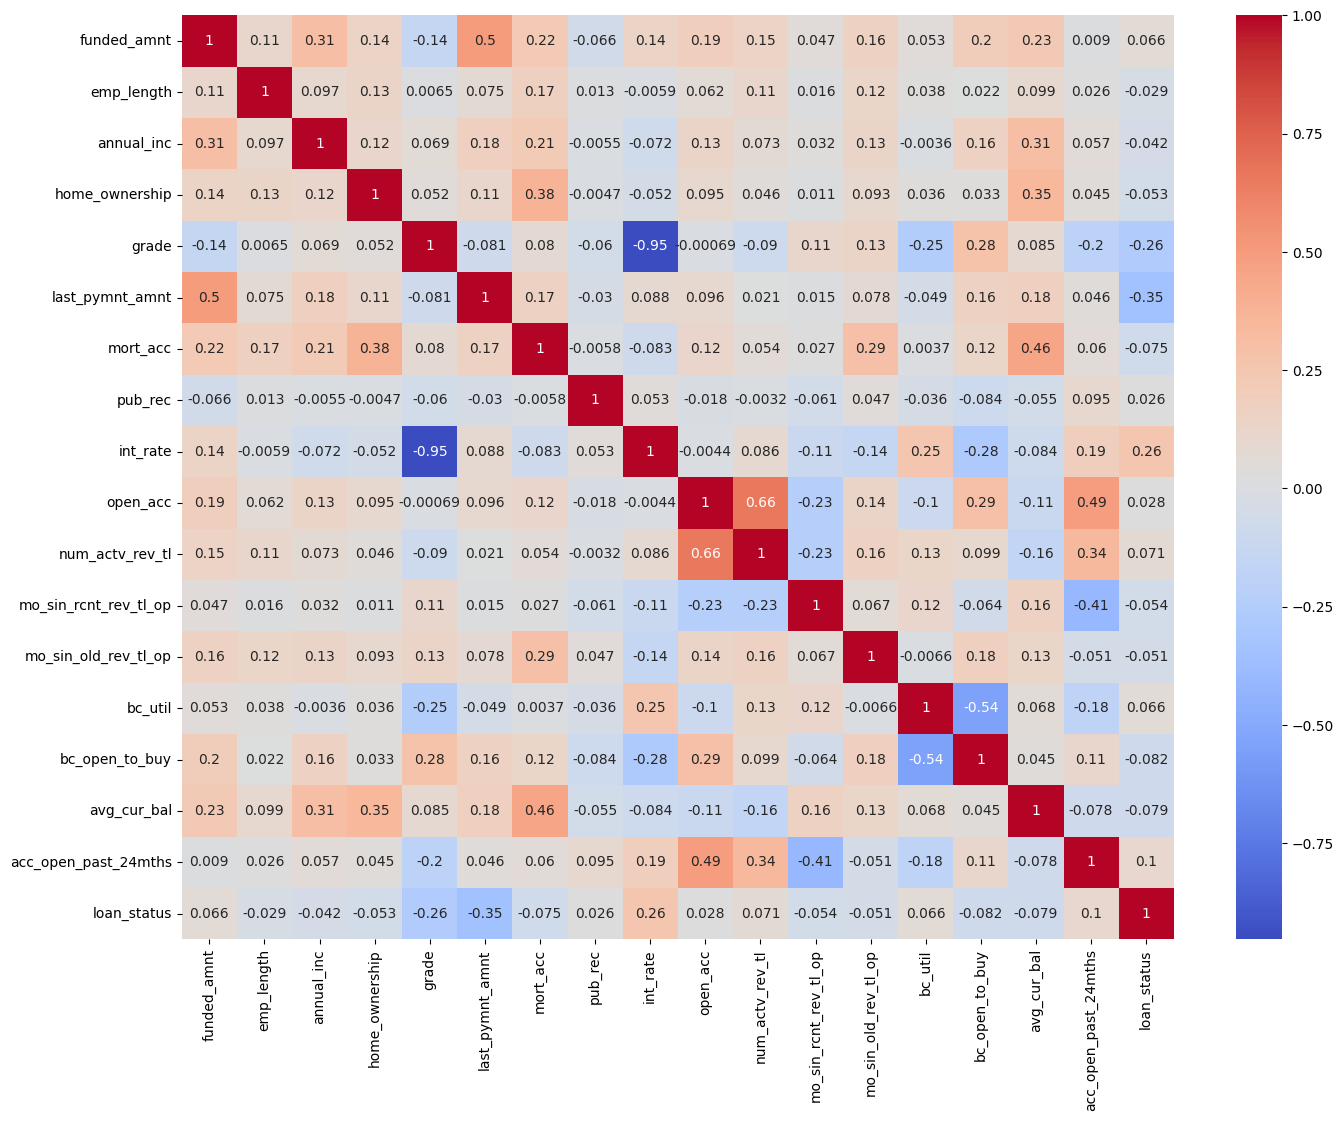

In [13]:
plt.figure(figsize=(16, 12))
sns.heatmap(Final_data.corr(), annot=True, cmap='coolwarm')

- int_rate and grade columns are highly correlated. Let dive deep and investigate these features in detail

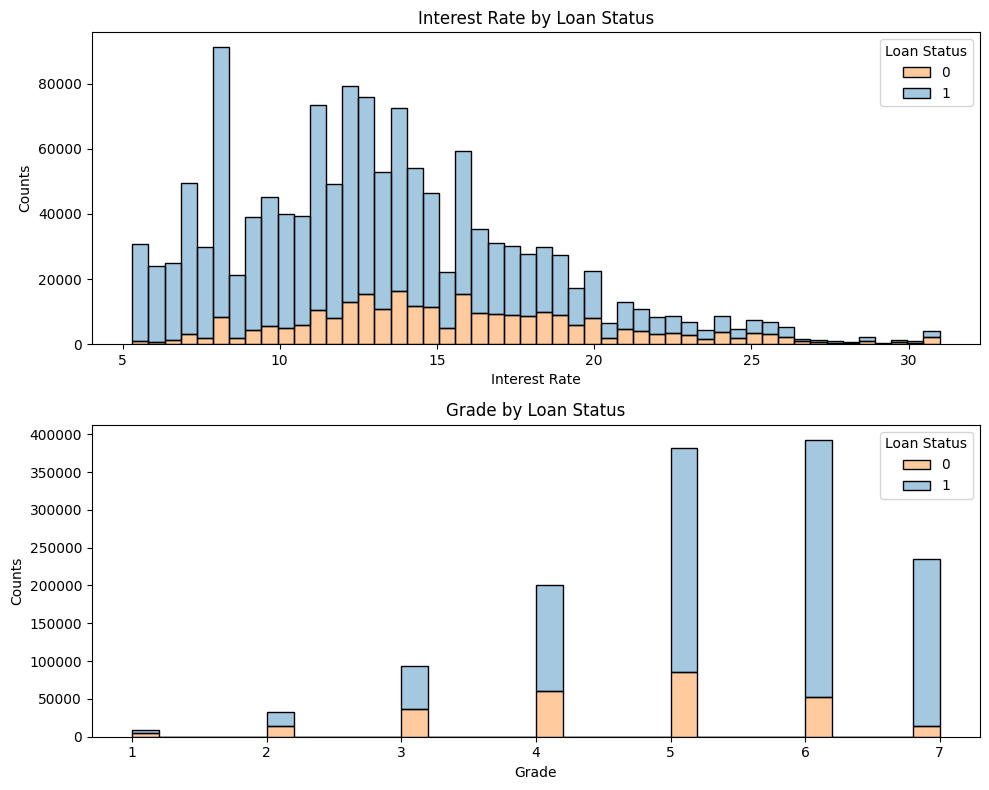

In [14]:

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histogram for Interest Rate by Loan Status
sns.histplot(
    data=Final_data,
    x='int_rate',
    hue='loan_status',
    multiple='stack',
    bins=50,
    alpha=0.4,
    ax=axes[0]
)
axes[0].set_title("Interest Rate by Loan Status")
axes[0].set_xlabel('Interest Rate')
axes[0].set_ylabel('Counts')
# Customize legend
axes[0].legend(title='Loan Status', loc='upper right', labels=Final_data['loan_status'].unique())

# Plot histogram for Grade by Loan Status
sns.histplot(
    data=Final_data,
    x='grade',
    hue='loan_status',
    multiple='stack',
    bins=30,
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_title("Grade by Loan Status")
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Counts')
# Customize legend
axes[1].legend(title='Loan Status', loc='upper right', labels=Final_data['loan_status'].unique())

# Adjust layout
plt.tight_layout()
plt.show()

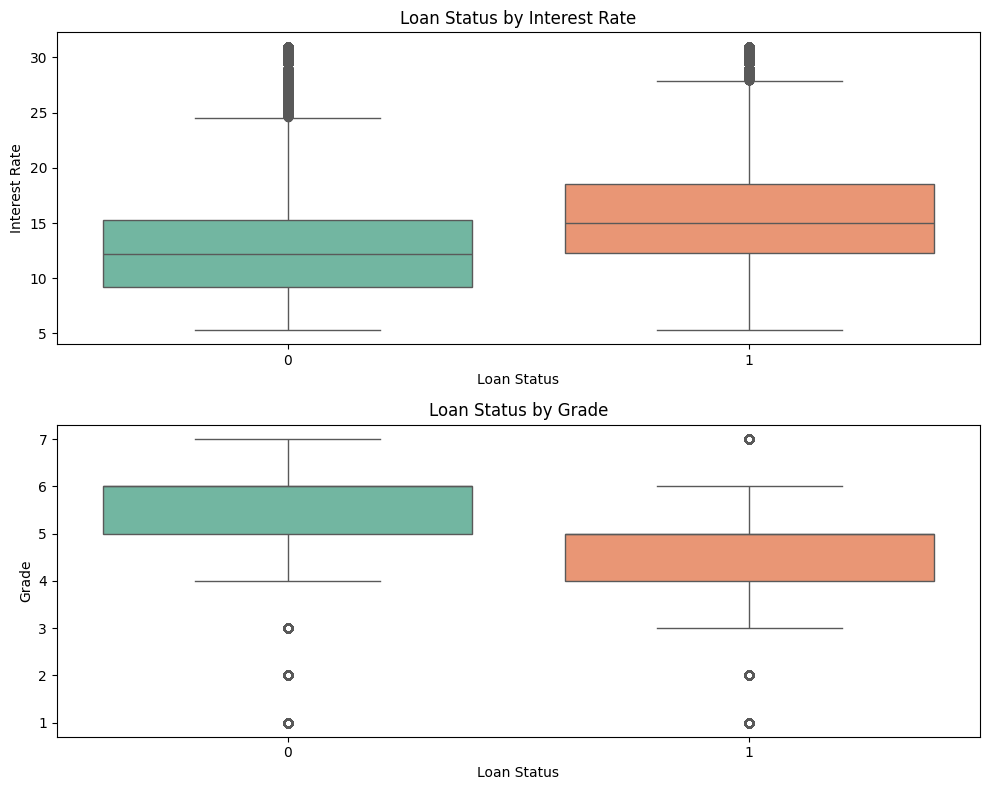

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Box plot for Interest Rate by Loan Status
sns.boxplot(
    data=Final_data,
    x='loan_status',
    y='int_rate',
    ax=axes[0],
    palette='Set2'
)
axes[0].set_title("Loan Status by Interest Rate")
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Interest Rate')

# Box plot for Grade by Loan Status
sns.boxplot(
    data=Final_data,
    x='loan_status',
    y='grade',
    ax=axes[1],
    palette='Set2'
)
axes[1].set_title("Loan Status by Grade")
axes[1].set_xlabel('Loan Status')
axes[1].set_ylabel('Grade')

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
Final_data.groupby(by='loan_status')['int_rate'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1076751.0,12.62,4.53,5.31,9.17,12.23,15.31,30.99
1,268559.0,15.71,4.91,5.31,12.29,15.05,18.55,30.99


In [17]:
Final_data.groupby(by='loan_status')['grade'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1076751.0,5.42,1.23,1.0,5.0,6.0,6.0,7.0
1,268559.0,4.58,1.32,1.0,4.0,5.0,5.0,7.0


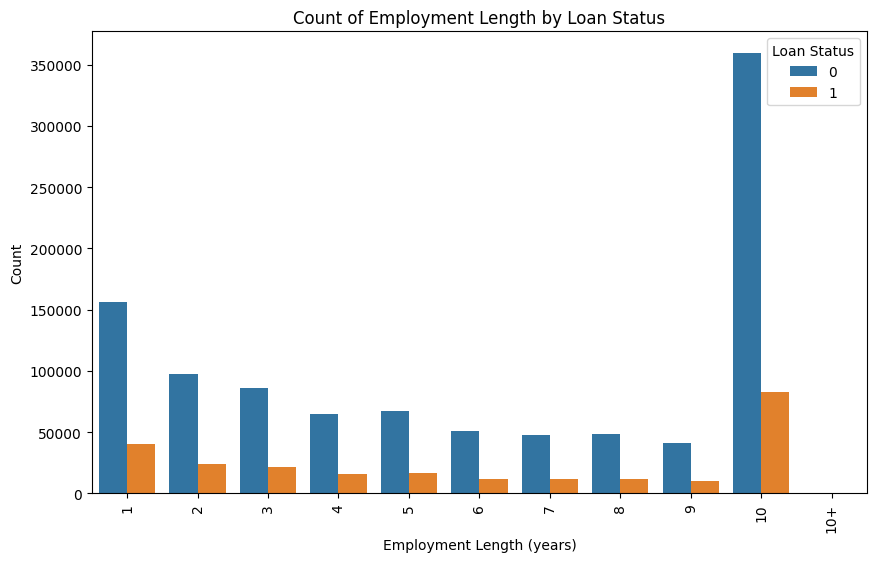

In [18]:
# Set the order for the employee length
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '10+']

# Create a count plot for employment length by loan status
plt.figure(figsize=(10, 6))
g = sns.countplot(x='emp_length', data=Final_data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Set titles and labels
plt.title('Count of Employment Length by Loan Status')
plt.xlabel('Employment Length (years)')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

- Correlation between Loan Status and Numeric Features

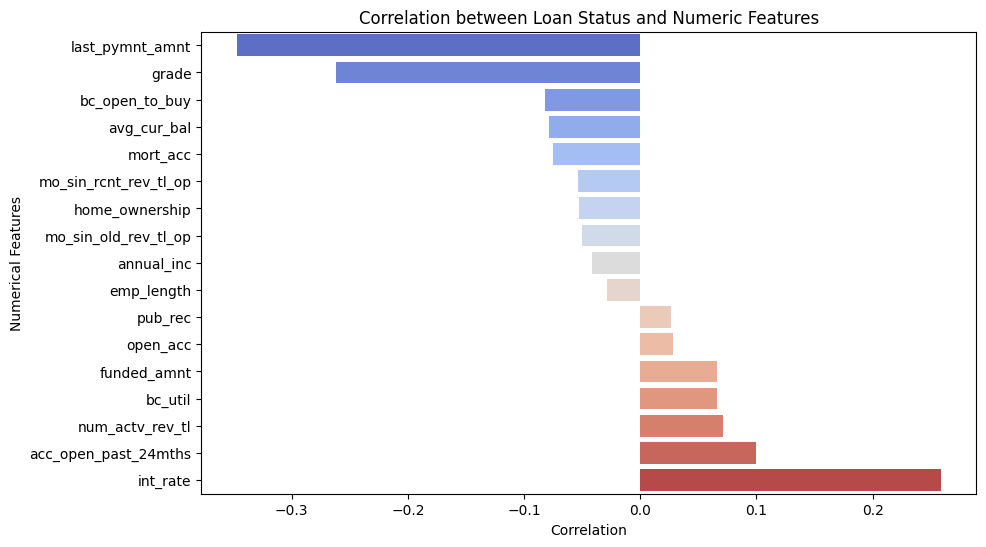

In [19]:
correlation = Final_data.corr()['loan_status'].drop('loan_status').sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette='coolwarm')
plt.title("Correlation between Loan Status and Numeric Features")
plt.xlabel('Correlation')
plt.ylabel('Numerical Features')
plt.show()

## Filling Missing values and Feature scaling


- Some important features had missing values, which were filled with the column mean.
- All features were scaled using a standard scaler.
- The dataset was sampled based on insights from the plotted learning curve.

In [20]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (1345310, 18)


In [21]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

,count
loan_status,
0,1076751
1,268559


In [22]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5000)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (10000, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,0.411844,1.151525,-0.232358,0.907775,-1.740594,-0.689218,-0.341370,4.626829,2.254356,0.256948,0.110794,-0.760766,-0.732617,-0.106373,-0.591630,0.369966,3.931604,1
1,-0.001326,-0.722194,-0.329347,0.907775,-1.740594,-0.708892,-0.341370,-0.357682,1.316997,0.074259,-0.821504,-0.446807,-0.591471,0.096272,-0.322727,-0.402546,0.417572,1
2,-1.080160,1.151525,-0.432572,-0.570474,0.575883,-0.739369,-0.850282,-0.357682,-0.731774,-0.108430,-0.199972,-0.007265,-0.005169,1.377279,-0.501351,-0.622697,0.417572,1
3,-0.047234,-1.257542,0.339683,0.907775,-0.196276,0.499059,0.167542,-0.357682,-0.094285,0.439637,-0.199972,-0.321224,-0.602328,0.367672,-0.400471,0.417335,0.098115,0
4,-1.103114,-1.525216,-0.718593,-0.570474,0.575883,-0.740037,-0.850282,-0.357682,-0.576595,-1.021874,-0.510738,0.306694,-0.754332,1.373661,-0.676709,-0.800771,-0.540800,1


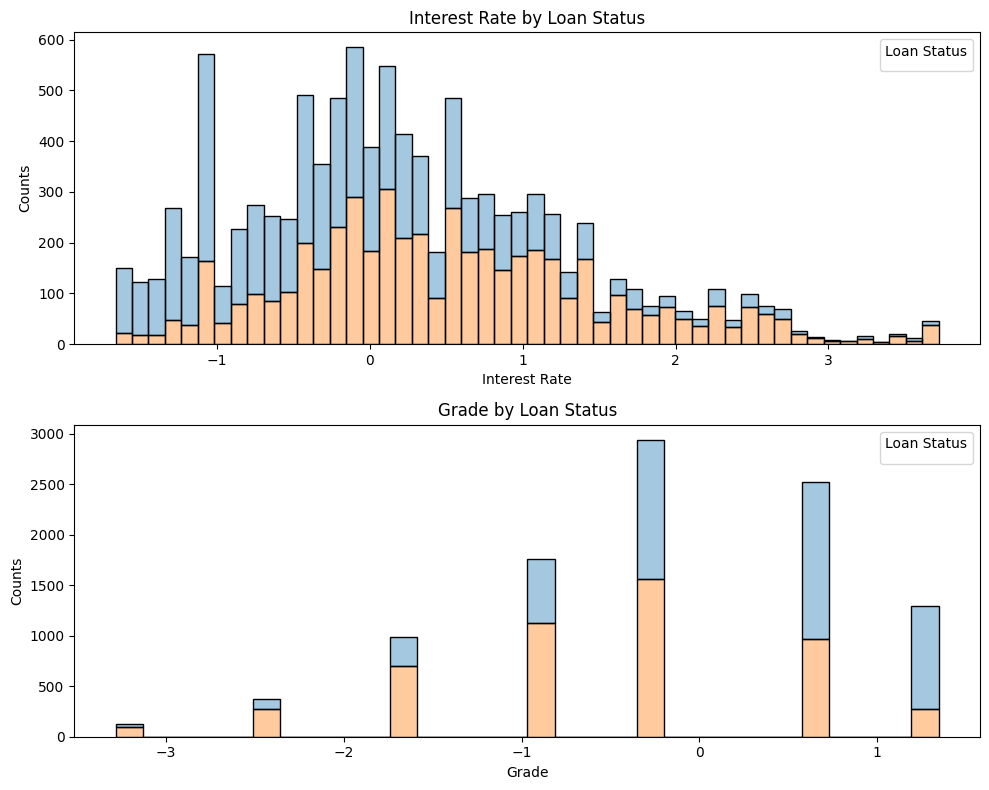

In [23]:

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histogram for Interest Rate by Loan Status
sns.histplot(data=data_clean, x='int_rate', hue='loan_status', multiple='stack', bins=50, alpha=0.4, ax=axes[0])
axes[0].set_title("Interest Rate by Loan Status")
axes[0].set_xlabel('Interest Rate')
axes[0].set_ylabel('Counts')
axes[0].legend(title='Loan Status', loc='upper right')

# Plot histogram for Grade by Loan Status
sns.histplot(data=data_clean, x='grade', hue='loan_status', multiple='stack', bins=30, alpha=0.4, ax=axes[1])
axes[1].set_title("Grade by Loan Status")
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Counts')
axes[1].legend(title='Loan Status', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

## Learning Curve

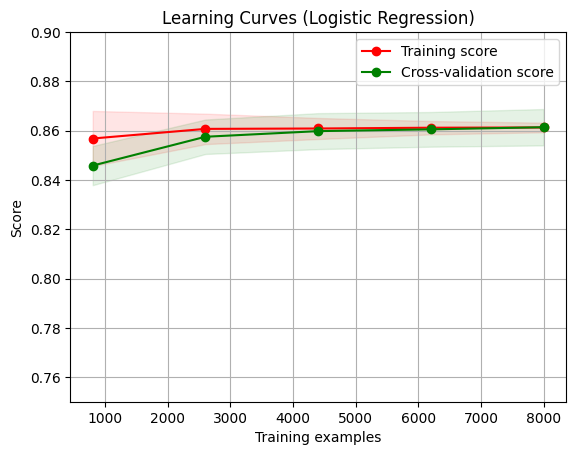

In [24]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.90), cv=cv, n_jobs=4)
plt.show()

## ROC Curve plot function

In [25]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic
    plt.legend(loc="lower right")

## Confusion Matrix Viz function

In [26]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = 'coolwarm'
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [28]:
X_train.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths
9254,-0.038626,0.080828,-0.203756,0.907775,-1.740594,-0.683863,0.167542,2.965325,2.359206,-0.839185,-0.821504,-0.132848,-1.525211,1.134829,-0.657239,0.595598,-0.221342
1561,0.182305,-0.722194,0.361306,0.907775,-0.968435,0.476855,0.676454,-0.357682,0.497069,0.256948,0.421560,-0.572391,0.092548,0.577554,-0.512086,0.137847,1.056487
1670,-0.506312,-0.454520,0.053663,-0.570474,-0.196276,-0.713600,-0.850282,-0.357682,0.262205,-0.656496,-1.132270,-0.635183,-0.830334,-2.169012,-0.479148,-0.673593,0.417572
6087,-0.506312,-0.722194,-0.446873,-0.570474,0.575883,-0.396224,-0.850282,-0.357682,0.178325,1.718459,1.664623,-0.509599,-0.450324,0.479850,-0.375001,-0.679515,-0.221342
6669,-1.011298,1.151525,0.282479,-2.048722,0.575883,-0.735997,1.694279,-0.357682,-0.358507,0.622326,1.043091,-0.635183,2.589761,-0.717928,2.030131,-0.143404,-0.221342


###  Feature Selection using RFE (Recursive Feature Elimination)

In [29]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(estimator = clf_LR, n_features_to_select = 10)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True False  True False  True  True  True False  True False  True  True
 False False  True False  True]
[1 2 1 5 1 1 1 3 1 6 1 1 4 7 1 8 1]


In [30]:
#PCA (Principal Component Analysis)
from sklearn.decomposition import PCA
pca = PCA(n_components=10, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.15568986 0.15481617 0.12134143 0.07816303 0.07048663 0.06087979
 0.05704796 0.05387204 0.04661445 0.04216968]


In [31]:
features = ['funded_amnt','annual_inc','grade',"last_pymnt_amnt", "int_rate",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy","acc_open_past_24mths","loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8000, 10)
(10000, 11)


<Axes: >

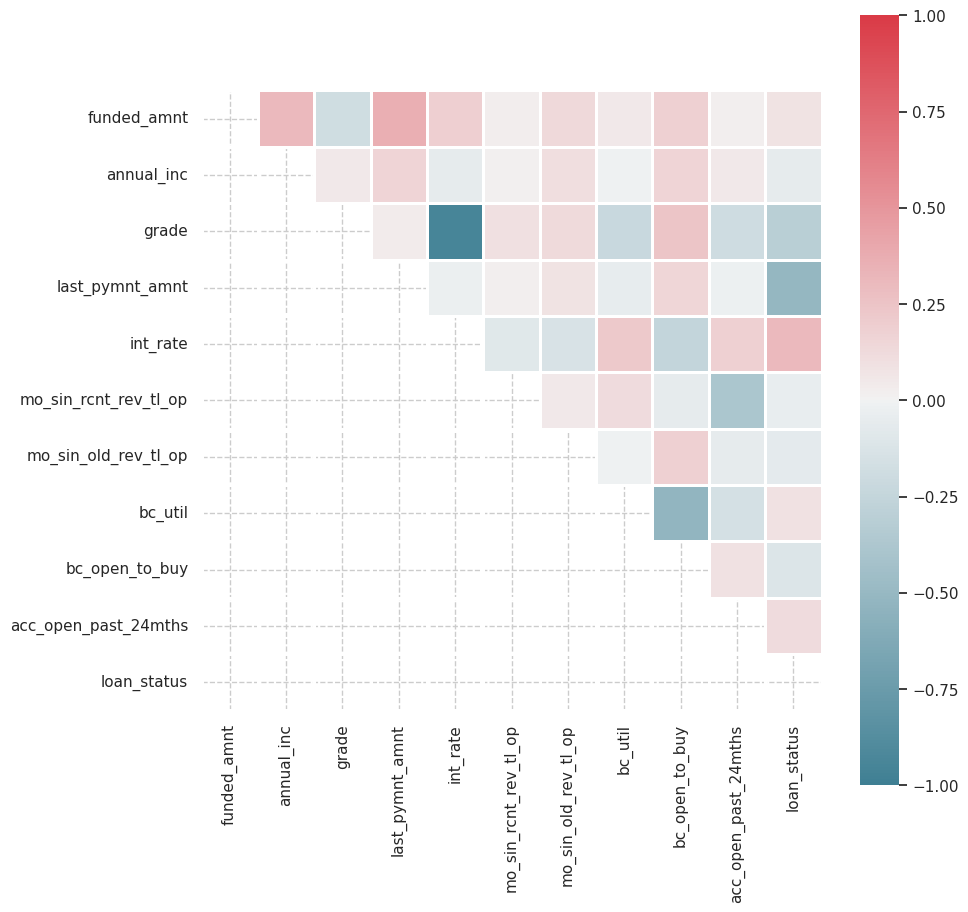

In [32]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10))
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

# Models


## Random Forest with randomized Search

In [33]:
from sklearn.model_selection  import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1])
param_dist = {'max_features': maxFeatures}
rand = RandomizedSearchCV(rf, param_distributions = param_dist, cv=5, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
mean_scores = rand.cv_results_['mean_test_score']
print('Mean Scores:', mean_scores)
print('Best Accuracy:', rand.best_score_)
print('Best Estimator:', rand.best_estimator_)

Mean Scores: [0.8603 0.8692 0.8716 0.8722 0.8736 0.8729 0.8713 0.8698 0.8727 0.8723]
Best Accuracy: 0.8736
Best Estimator: RandomForestClassifier(max_features=5, random_state=0)


In [34]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.8805


## Feature Importance

Text(0, 0.5, 'Normalized Gini Importance')

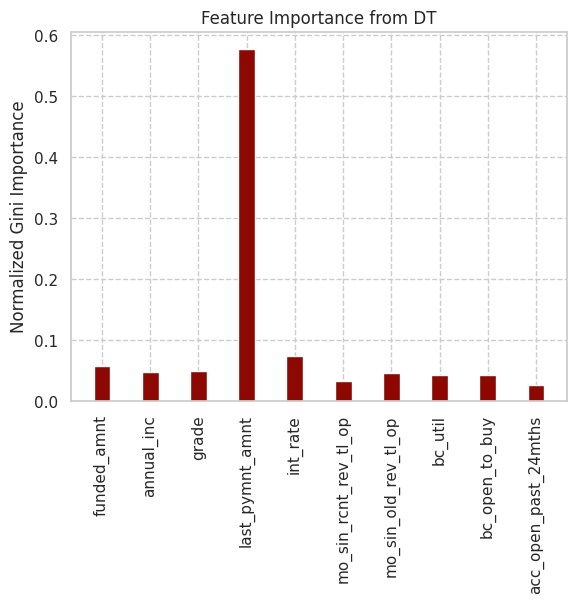

In [35]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

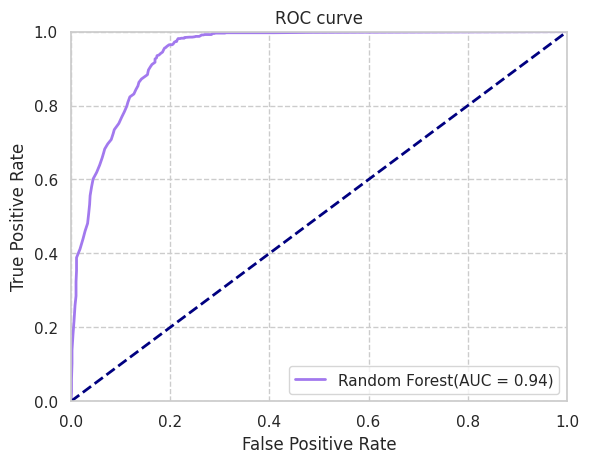

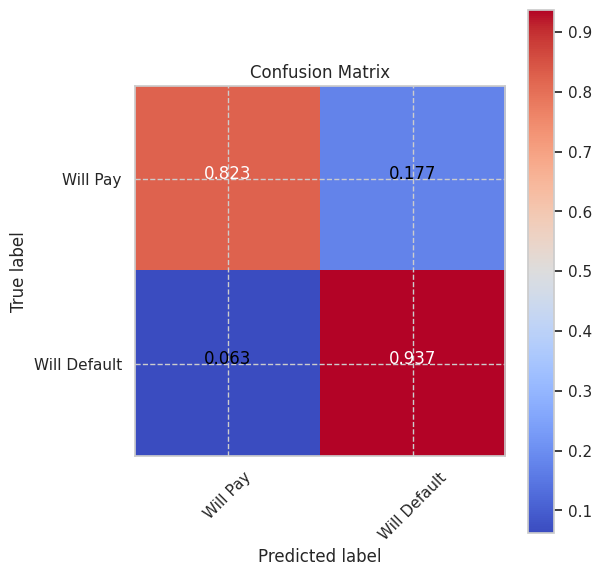

In [36]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

## Logistic Regression with Grid Search


In [37]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = 5)
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = grid.cv_results_['mean_test_score']
    # Get best accuracy and best classifier
    best_accuracy = grid.best_score_
    best_classifier = grid.best_estimator_
    return mean_scores, best_accuracy, best_classifier
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores, best_accuracy, best_classifier = cross_validation_best_parameters(logreg, param_grid)
print("Best accuracy is "+ str(best_accuracy))
print(best_classifier)

Best accuracy is 0.8620999999999999
LogisticRegression(C=1000, random_state=0)


Logistic regression accuracy is  0.862


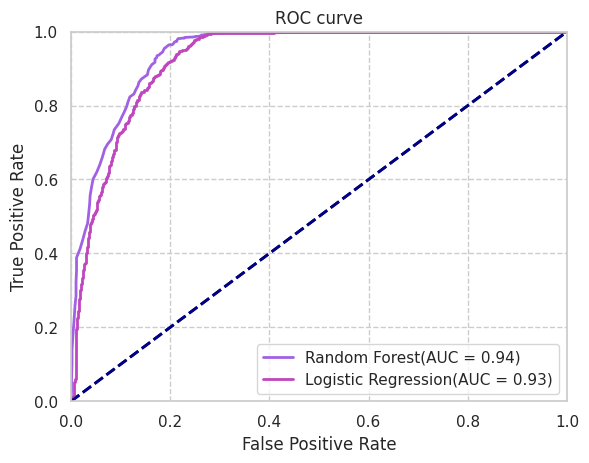

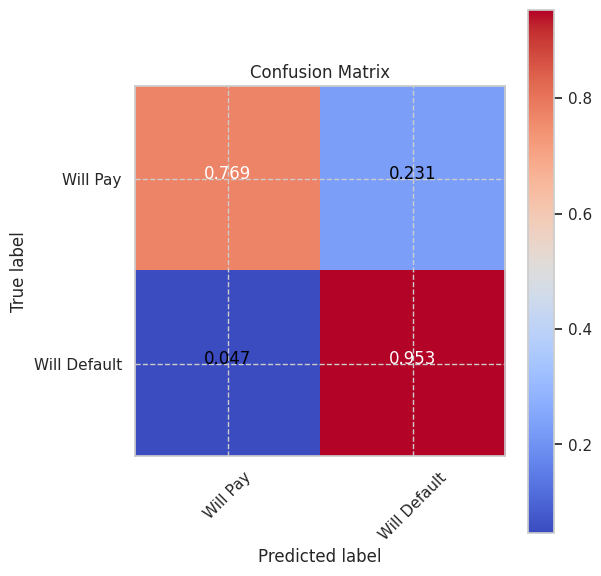

In [38]:
clf_LR = linear_model.LogisticRegression(C=best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

## Support Vector Machines(SVM) with Grid Search CV

In [39]:
from sklearn.model_selection import GridSearchCV    ## takes too much time to run this cell.
clf_svm = svm.SVC()
powers = range(0,5)
cs = [10**i for i in powers]
param_grid = {'C': cs}
grid = GridSearchCV(clf_svm, param_grid, cv=5, scoring='accuracy', n_jobs = -1, verbose=3)
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
grid.fit(X, y)
grid_mean_scores = grid.cv_results_['mean_test_score']# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 10}
---------------
SVC(C=10)


SVM accuracy is  0.853


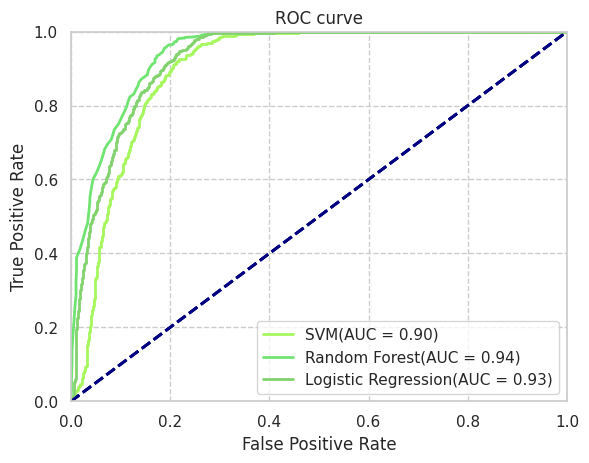

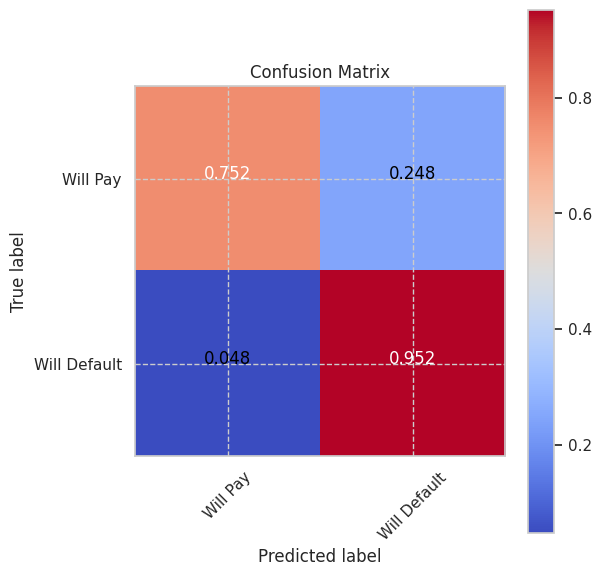

In [40]:
clf_svm = svm.SVC(kernel = "rbf", C=grid.best_estimator_.C)
clf_svm.fit(X_train.iloc[:,:],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,:])
predictproba_svm = clf_svm.decision_function(X_test.iloc[:,:])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

## K Nearest Neighbors(KNN) with Grid Search CV

In [41]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.model_selection import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=5, scoring='accuracy')
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
grid.fit(X, y)
grid_mean_scores = grid.cv_results_['mean_test_score']# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 45}
---------------
KNeighborsClassifier(n_neighbors=45)


 45
KNN accuracy is  0.792


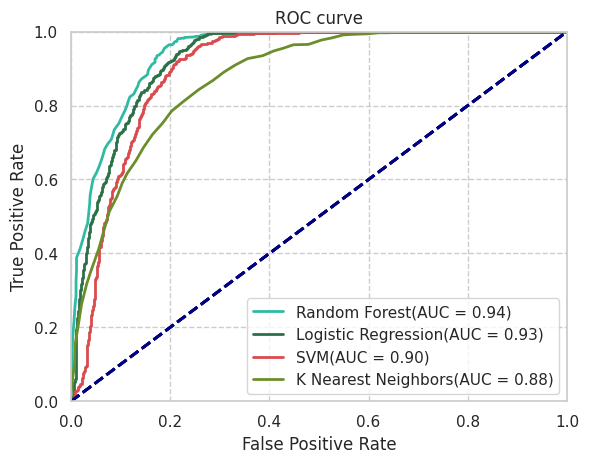

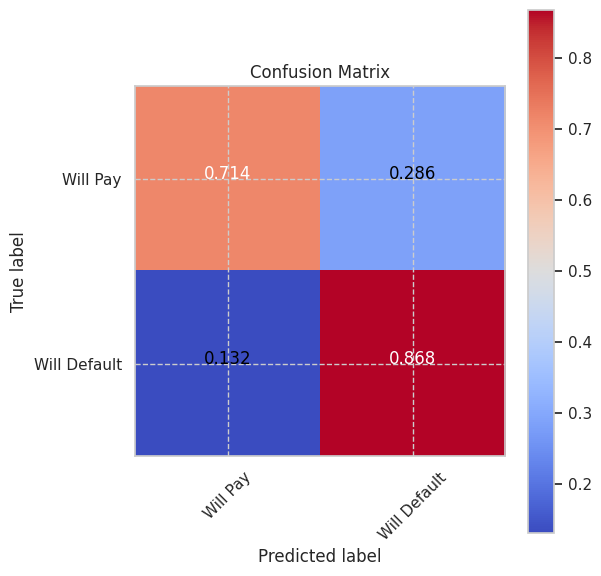

In [42]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

## Bagging for Classification

In [43]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
seed = 7
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)
num_trees = 100
randomForest = RandomForestClassifier(random_state=seed)  # Initialize RandomForest properly
model = BaggingClassifier(estimator=randomForest, n_estimators=num_trees, random_state=seed)
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print(f"Mean Accuracy: {results.mean()}")


Mean Accuracy: 0.8705999999999999


In [44]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
seed = 7
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)
# Initialize the Logistic Regression classifier
clf_LR = LogisticRegression(C=1.0, max_iter=1000, random_state=seed)  # Adjusted hyperparameters if needed
model = BaggingClassifier(estimator=clf_LR, n_estimators=10, random_state=seed)
# Perform cross-validation
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
results = model_selection.cross_val_score(model, X, y, cv=kfold)
# Print the average accuracy
print(f"Mean Accuracy: {results.mean():.4f}")

Mean Accuracy: 0.8596


## Ada Boost classifier

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50, random_state=0)
# Use X and y for training and testing (as defined in previous cases)
X = data_clean.iloc[:, :-1].values
y = data_clean.iloc[:, -1].values
# Perform cross-validation with 5 folds and calculate accuracy
scores = cross_val_score(Ada_clf, X, y, cv=5, scoring='accuracy')
# Print the mean accuracy
print(f"Mean Accuracy: {scores.mean():.4f}")

Mean Accuracy: 0.8661


## Multi-Layer Perceptron Classifier

0.8665


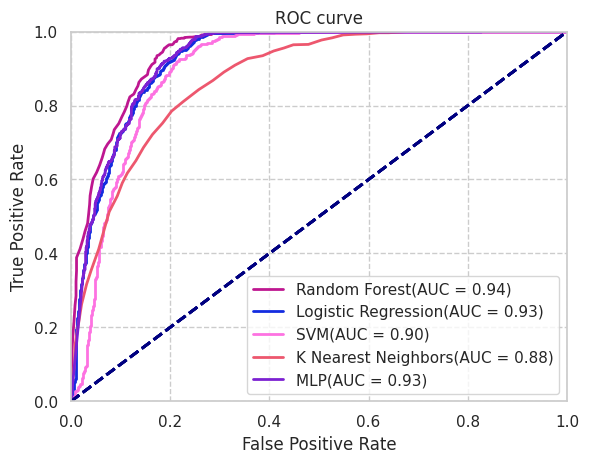

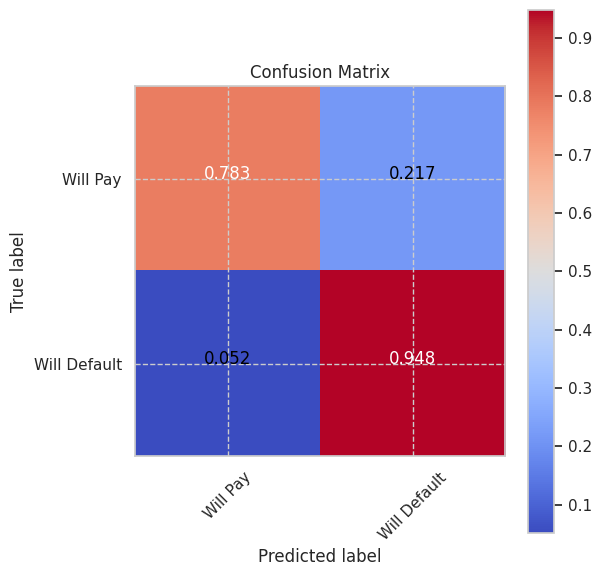

In [46]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf_NN.fit(X_train,y_train)
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

## Artificial Neural Networks (ANN)

In [47]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    assert len(dropout_rates) == len(hidden_units) + 1, "Dropout rates must have one more element than hidden units."
    inp = Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

Convert to numpy arrays

In [48]:
X_nn_train = np.array(X_train)
y_nn_train = np.array(y_train)
X_nn_test = np.array(X_test)
y_nn_test = np.array(y_test)

In [49]:
num_columns = X_nn_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

model = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_test, y_nn_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
250/250 [==============================] - 3s 5ms/step - loss: 0.4732 - AUC: 0.8541 - val_loss: 0.4108 - val_AUC: 0.9028
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4250 - AUC: 0.8780 - val_loss: 0.3650 - val_AUC: 0.9119
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4071 - AUC: 0.8854 - val_loss: 0.3495 - val_AUC: 0.9181
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.4018 - AUC: 0.8863 - val_loss: 0.3298 - val_AUC: 0.9248
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.3884 - AUC: 0.8927 - val_loss: 0.3225 - val_AUC: 0.9263
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.3769 - AUC: 0.8971 - val_loss: 0.3211 - val_AUC: 0.9257
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.3759 - AUC: 0.8982 - val_loss: 0.3199 - val_AUC: 0.9271
Epoch 8/100
250/250 [==============================] - 1s 3ms/step - 

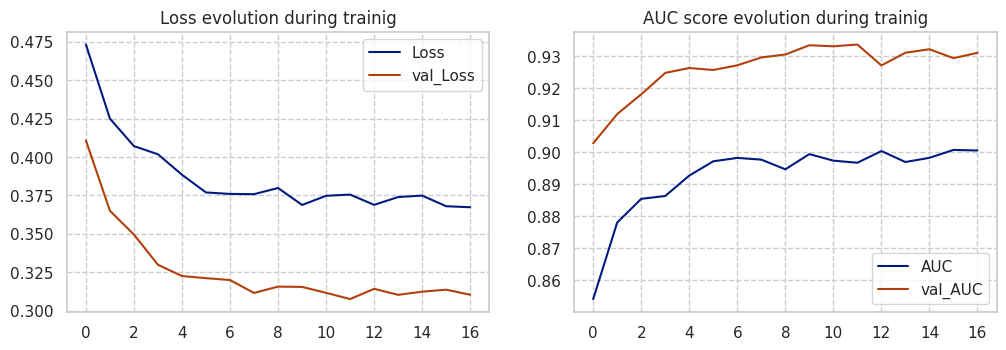

In [50]:
plot_learning_evolution(r)

In [51]:
y_train_pred = model.predict(X_nn_train)
evaluate_nn(y_nn_train, y_train_pred.round(), train=True)

250/250 [==============================] - 1s 2ms/step
Train Result:
Accuracy Score: 86.31%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.969142     0.795664  0.863125     0.882403      0.882706
recall        0.751121     0.975916  0.863125     0.863518      0.863125
f1-score      0.846316     0.876620  0.863125     0.861468      0.861415
support    4014.000000  3986.000000  0.863125  8000.000000   8000.000000
_______________________________________________
Confusion Matrix: 
 [[3015  999]
 [  96 3890]]



In [52]:
y_test_pred = model.predict(X_nn_test)
evaluate_nn(y_nn_test, y_test_pred.round(), train=False)

63/63 [==============================] - 0s 2ms/step
Test Result:
Accuracy Score: 86.60%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.971129     0.801292     0.866     0.886211      0.885022
recall       0.750507     0.978304     0.866     0.864405      0.866000
f1-score     0.846682     0.880995     0.866     0.863838      0.864078
support    986.000000  1014.000000     0.866  2000.000000   2000.000000
_______________________________________________
Confusion Matrix: 
 [[740 246]
 [ 22 992]]



## Precision,recall,F1score for all models

In [53]:
from sklearn.metrics import classification_report
import pandas as pd
from tabulate import tabulate
reports = {
    "RF" : classification_report(y_test, rfPredict, target_names=["Will Pay", "Will Default"], output_dict=True),
    "SVM" : classification_report(y_test, predictions_svm, target_names=["Will Pay", "Will Default"], output_dict=True),
    "LR" : classification_report(y_test, LR_Predict_bin, target_names=["Will Pay", "Will Default"], output_dict=True),
    "KNN" : classification_report(y_test, knn_pred, target_names=["Will Pay", "Will Default"], output_dict=True),
    "MLP" : classification_report(y_test, predict_NN, target_names=["Will Pay", "Will Default"], output_dict=True),
    "ANN": classification_report(y_nn_test, y_test_pred.round(), target_names=["Will Pay", "Will Default"], output_dict=True)
}

df_reports = pd.concat([pd.DataFrame(report).transpose() for report in reports.values()], keys = reports.keys())
print(tabulate(df_reports, headers = 'keys', tablefmt = 'fancy_grid'))


╒═════════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│                         │   precision │   recall │   f1-score │   support │
╞═════════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ ('RF', 'Will Pay')      │    0.926857 │ 0.822515 │   0.871574 │  986      │
├─────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ('RF', 'Will Default')  │    0.844444 │ 0.936884 │   0.888266 │ 1014      │
├─────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ('RF', 'accuracy')      │    0.8805   │ 0.8805   │   0.8805   │    0.8805 │
├─────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ('RF', 'macro avg')     │    0.885651 │ 0.879699 │   0.87992  │ 2000      │
├─────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ('RF', 'weighted avg')  │    0.885074 │ 0.8805   │   0.880037 │ 2000      │
├─────────────────────────┼─────────────┼──────────┼────────────

In [54]:
df_reports

precision    recall  f1-score    support
RF  Will Pay       0.926857  0.822515  0.871574   986.0000
    Will Default   0.844444  0.936884  0.888266  1014.0000
    accuracy       0.880500  0.880500  0.880500     0.8805
    macro avg      0.885651  0.879699  0.879920  2000.0000
    weighted avg   0.885074  0.880500  0.880037  2000.0000
SVM Will Pay       0.937975  0.751521  0.834459   986.0000
    Will Default   0.797521  0.951677  0.867806  1014.0000
    accuracy       0.853000  0.853000  0.853000     0.8530
    macro avg      0.867748  0.851599  0.851133  2000.0000
    weighted avg   0.866764  0.853000  0.851366  2000.0000
LR  Will Pay       0.940447  0.768763  0.845982   986.0000
    Will Default   0.809045  0.952663  0.875000  1014.0000
    accuracy       0.862000  0.862000  0.862000     0.8620
    macro avg      0.874746  0.860713  0.860491  2000.0000
    weighted avg   0.873826  0.862000  0.860694  2000.0000
KNN Will Pay       0.840095  0.713996  0.771930   986.0000
    Will Default   0.757315  0.867850  0.808824  1014.0000
    accuracy       0.792000  0.792000  0.792000     0.7920
    macro avg      0.798705  0.790923  0.790377  2000.0000
    weighted avg   0.798126  0.792000  0.790635  2000.0000
MLP Will Pay       0.935758  0.782961  0.852568   986.0000
    Will Default   0.817872  0.947732  0.878026  1014.0000
    accuracy       0.866500  0.866500  0.866500     0.8665
    macro avg      0.876815  0.865347  0.865297  2000.0000
    weighted avg   0.875990  0.866500  0.865475  2000.0000
ANN Will Pay       0.971129  0.750507  0.846682   986.0000
    Will Default   0.801292  0.978304  0.880995  1014.0000
    accuracy       0.866000  0.866000  0.866000     0.8660
    macro avg      0.886211  0.864405  0.863838  2000.0000
    weighted avg   0.885022  0.866000  0.864078  2000.0000

## Behaviour of models with different sample sizes of dataset

- Plotted the ROC AUC score across various sample sizes to evaluate model performance.

In [55]:
def modBootstrapper(train, test, nruns, sampsize, model, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (model == "LR"):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target, axis = 1), train_samp[target]) #Logistic regression
            p = lr_i.predict_proba(test.drop(target, axis = 1))[:,1]
        elif (model == "SVM"):
            svm_i = svm.SVC(kernel='rbf', C = c)
            svm_i.fit(train_samp.drop(target, axis = 1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target, axis = 1))
        elif (model == "RF"):
            RF_i = RandomForestClassifier(bootstrap=True,criterion = "gini")
            RF_i.fit(train_samp.drop(target, axis = 1), train_samp[target])
            p = RF_i.predict_proba(X_test)[:,1]
        elif (model == "KNN"):
            knn_i = KNeighborsClassifier(n_neighbors= 30) #taking the the best from the above cell and using it to find predictions
            knn_i.fit(train_samp.drop(target, axis = 1), train_samp[target])
            p = knn_i.predict_proba(X_test)[:,1]

        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping

    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

In [56]:
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping
SampleSizes = [250,1000,1500,2000,2750,3750,4500,5200,6500,7000,8000,8500,9000,10000,11000] #various samples of Dataset
LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
RF_means = []
RF_stderr = []
KNN_means = []
KNN_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, "LR", 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n,"SVM", 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    mean3, err3 = modBootstrapper(bs_train, bs_test, 20, n,"RF", 0.1)# collecting means and stderrs for SVM model
    RF_means.append(mean3)
    RF_stderr.append(err3)
    mean4, err4 = modBootstrapper(bs_train, bs_test, 20, n,"KNN", 0.1)# collecting means and stderrs for SVM model
    KNN_means.append(mean4)
    KNN_stderr.append(err4)
    print(n)

250
1000
1500
2000
2750
3750
4500
5200
6500
7000
8000
8500
9000
10000
11000


Text(0, 0.5, 'roc_auc_score')

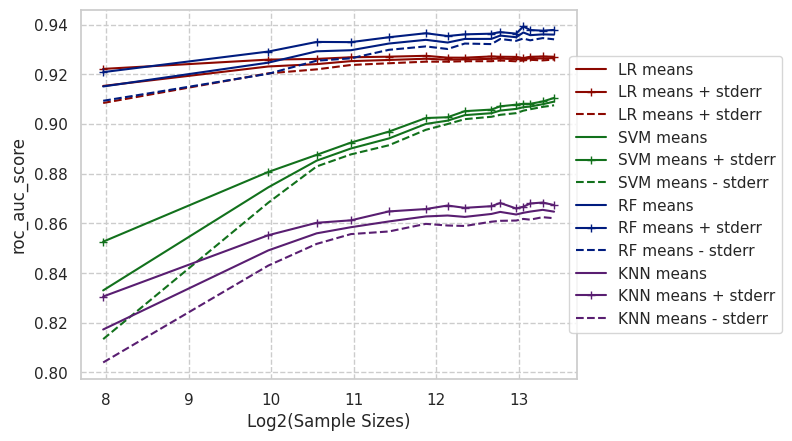

In [57]:
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-', label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.plot(np.log2(SampleSizes), RF_means, 'b', label = 'RF means')
plt.plot(np.log2(SampleSizes), RF_means + np.array(RF_stderr), 'b+-', label = 'RF means + stderr')
plt.plot(np.log2(SampleSizes), RF_means - np.array(RF_stderr), 'b--', label = 'RF means - stderr')

plt.plot(np.log2(SampleSizes), KNN_means, 'm', label = 'KNN means')
plt.plot(np.log2(SampleSizes), KNN_means + np.array(KNN_stderr), 'm+-', label = 'KNN means + stderr')
plt.plot(np.log2(SampleSizes), KNN_means - np.array(KNN_stderr), 'm--', label = 'KNN means - stderr')

plt.legend(bbox_to_anchor=(1.20, 0.5),loc = 10)
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')